<a href="https://colab.research.google.com/github/OneSll/Age_gender_recognition/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.__version__)

9.4.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import os

Перекидываем датасет с гугл диска в текущую рабочую директорию

In [ ]:
!cp -r /content/gdrive/MyDrive/SRW /content

Переименовываем файлы для удобства

In [ ]:
def rename_files_in_folder(folder_path):
    # Получаем список файлов в указанной папке
    files = os.listdir(folder_path)
    k = 0

    # Проходим по каждому файлу и переименовываем его
    for file_name in files:
        # Формируем новое имя файла
        k += 1
        new_file_name = f"pic_{k}.jpg"

        # Полный путь к текущему файлу
        old_file_path = os.path.join(folder_path, file_name)
        # Полный путь к новому файлу
        new_file_path = os.path.join(folder_path, new_file_name)

        # Переименовываем файл
        os.rename(old_file_path, new_file_path)
        #print(f"Переименован файл: {old_file_path} -> {new_file_path}")

In [ ]:
traint_set_folder = "/content/SRW/train/simpsons_dataset"
for dir in os.listdir(traint_set_folder):
  rename_files_in_folder(traint_set_folder + "/" + dir)

Проверяем доступность GPU

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Работа с данными

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        # Добавляем аугментацию данных
        if self.mode == 'train':
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=45),
                transforms.ColorJitter(brightness=0.5, contrast=0.3),
                transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.8, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

        elif self.mode == 'val':
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=45),
                transforms.ColorJitter(brightness=0.5, contrast=0.3),
                transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.8, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = x.convert('RGB')
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/content/SRW/train')
TEST_DIR = Path('./content/SRW/testset')

Посмотрим на наш тренировочный датасет

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

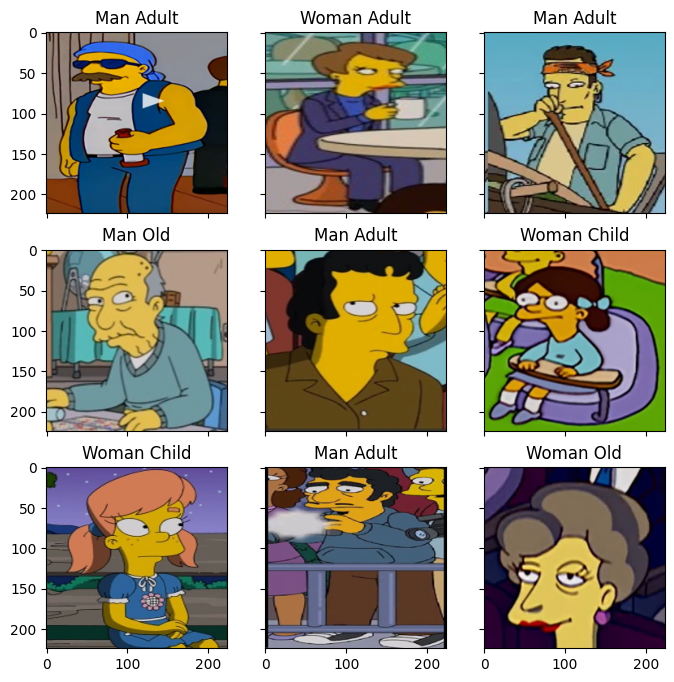

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
np.random.seed(12)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,799))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
from torch.optim import AdamW
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

Наша модель

In [ ]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)

        # Размораживаем последние три слоя
        for param in list(self.resnet.layer4.parameters()) + \
                     list(self.resnet.layer3.parameters()):
            param.requires_grad = True

        # Заменяем последний полносвязный слой на новый слой с количеством выходных классов
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

Функция для обучения

In [ ]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_predictions / total_predictions

    return epoch_loss, epoch_acc

Функция для итерации обучения

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs, device):
    train_history = []
    val_history = []

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}:')

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

        val_loss, val_acc = validate(model, val_loader, criterion, device)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        train_history.append((train_loss, train_acc))
        val_history.append((val_loss, val_acc))

    return train_history, val_history

Функция для валидации

In [ ]:
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = correct_predictions / total_predictions

    return epoch_loss, epoch_acc

Задаем параметры обучения

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 7
batch_size = 32

Задаем оптимизатор и функцию потерь

In [ ]:
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

Инициализируем модель

In [ ]:
n_classes = len(np.unique(train_val_labels))
model = CustomResNet(num_classes=n_classes).to(device)

Загружаем данные

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Обучаем модель

In [ ]:
train_history, val_history = train_model(model, train_loader, val_loader, optimizer, criterion, epochs, device)

Функция пердсказания для тестового датасета

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Функция предсказания для одной картинки

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

Сделаем оценку модели по F1 score

In [ ]:
np.random.seed(104)
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [ ]:
np.random.seed(104)
idxs = list(map(int, np.random.uniform(0,30, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

Выведем некоторые результаты модели

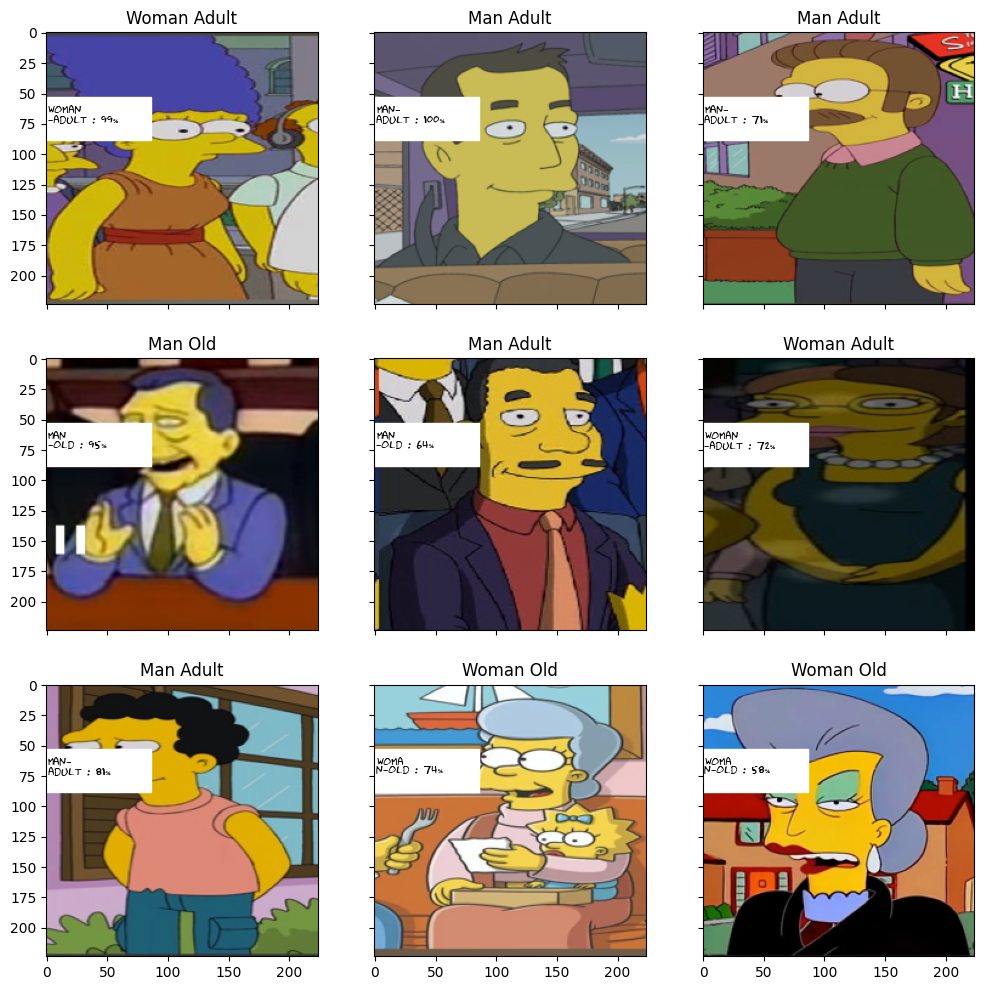

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
np.random.seed(52)

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,799))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Копируем веса в рабочую директорию

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

Перекидываем веса на диск

In [ ]:
!cp /content/model_weights.pth /content/gdrive/MyDrive